# Recommendation System - Model 1

## Import packages and dataframes

In [1]:
import numpy as np
import pandas as pd
import random as rd
from sklearn.preprocessing import OneHotEncoder as OHE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

rd.seed(123)

In [ ]:
# import all the files

donationsDF = pd.read_csv('Donations.csv')
donorsDF = pd.read_csv('Donors.csv')
projectsDF = pd.read_csv('Projects.csv')
schoolsDF = pd.read_csv('Schools.csv')
resourcesDF = pd.read_csv('Resources.csv')

In [27]:
acs_df = pd.read_csv('zip_wise_acs_2015.csv')

## Snapshot of the dataframes

In [ ]:
donationsDF.head(2)

In [ ]:
donorsDF.head(2)

In [ ]:
projectsDF.head(2)

## Remove one-time donors

In [3]:
donorsDF_merged = donorsDF.merge(donationsDF, on = 'Donor ID', how = 'inner') # donation ID is the primary key here

In [ ]:
donorsDF_merged.head(1)

In [4]:
# Get the count of donations a donor has made

df_temp1 = donorsDF_merged.groupby( ['Donor ID']).size().reset_index(name='Num Donations')

df_temp1.head(2)

,Donor ID,Num Donations
0,00000ce845c00cbf0686c992fc369df4,1
1,00002783bc5d108510f3f9666c8b1edd,1


In [5]:
df_temp2 = df_temp1[df_temp1['Num Donations'] > 1] # removing all the single-donors

print("We got rid of %d single-donors." % (df_temp1.shape[0] - df_temp2.shape[0]))

We got rid of 1466290 single-donors.


## Building dataframe for modeling

In [6]:
uniqDonorIDList = list(df_temp2['Donor ID']) # list of recurring donors
df_final = donorsDF_merged[donorsDF_merged['Donor ID'].isin(uniqDonorIDList)]


df_final.shape

(3215610, 11)

In [7]:
df_final = df_final.drop_duplicates(subset = ['Donation ID']) # removes duplicate Donation IDs

df_final.shape

(3215570, 11)

In [8]:
df_final = df_final.merge(projectsDF, on = "Project ID", how = "inner") # adding projects to the final dataframe

df_final.head(2)

,Donor ID,Donor City,Donor State,Donor Is Teacher,Donor Zip,Project ID,Donation ID,Donation Included Optional Donation,Donation Amount,Donor Cart Sequence,...,Project Need Statement,Project Subject Category Tree,Project Subject Subcategory Tree,Project Grade Level Category,Project Resource Category,Project Cost,Project Posted Date,Project Expiration Date,Project Current Status,Project Fully Funded Date
0,00002d44003ed46b066607c5455a999a,Winton,California,Yes,953,2f53e5f31890e647048ac217cda3b83f,7831f66a25935db8b7424170355edabf,No,26.0,10,...,My students need books to inspire them to be a...,"History & Civics, Literacy & Language","Civics & Government, Literacy",Grades 6-8,Books,373.53,2017-04-01,2017-08-01,Fully Funded,2017-05-12
1,00002d44003ed46b066607c5455a999a,Winton,California,Yes,953,2f53e5f31890e647048ac217cda3b83f,ee15bb7f179142fdff3f24cff8e88483,No,100.0,9,...,My students need books to inspire them to be a...,"History & Civics, Literacy & Language","Civics & Government, Literacy",Grades 6-8,Books,373.53,2017-04-01,2017-08-01,Fully Funded,2017-05-12


In [9]:
df_final = df_final.merge(schoolsDF, on = "School ID", how = "inner") # adding projects to the final dataframe

df_final.head(2)

,Donor ID,Donor City,Donor State,Donor Is Teacher,Donor Zip,Project ID,Donation ID,Donation Included Optional Donation,Donation Amount,Donor Cart Sequence,...,Project Current Status,Project Fully Funded Date,School Name,School Metro Type,School Percentage Free Lunch,School State,School Zip,School City,School County,School District
0,00002d44003ed46b066607c5455a999a,Winton,California,Yes,953,2f53e5f31890e647048ac217cda3b83f,7831f66a25935db8b7424170355edabf,No,26.0,10,...,Fully Funded,2017-05-12,Herbert Hoover Middle School,urban,82.0,California,95340,Merced,Merced,Merced City School District
1,00002d44003ed46b066607c5455a999a,Winton,California,Yes,953,2f53e5f31890e647048ac217cda3b83f,ee15bb7f179142fdff3f24cff8e88483,No,100.0,9,...,Fully Funded,2017-05-12,Herbert Hoover Middle School,urban,82.0,California,95340,Merced,Merced,Merced City School District


### Training and test split

In [10]:
columnsList = ['Donor ID', 'Donation Received Date', 'Donor City', 'Donor State',
       'Donor Is Teacher', 'Donor Zip', 'Project ID', 'Donation ID',
       'Donation Included Optional Donation', 'Donation Amount',
       'Donor Cart Sequence', 'School ID', 'Teacher ID',
       'Teacher Project Posted Sequence', 'Project Type', 'Project Title',
       'Project Essay', 'Project Short Description', 'Project Need Statement',
       'Project Subject Category Tree', 'Project Subject Subcategory Tree',
       'Project Grade Level Category', 'Project Resource Category',
       'Project Cost', 'Project Posted Date', 'Project Expiration Date',
       'Project Current Status', 'Project Fully Funded Date', 'School Name',
       'School Metro Type', 'School Percentage Free Lunch', 'School State',
       'School Zip', 'School City', 'School County', 'School District']

df_final = df_final[columnsList]

df_final = df_final.sort_values(by = ['Donor ID', 'Donation Received Date']) # sorts dataframe by donors and their
                                                                            # first donation date


In [11]:
donorsKeep = df_final.drop_duplicates(subset=['Donor ID'], keep='first') # keep just the first donation for each donor

donorsKeep = donorsKeep.sort_values(['Donation Received Date']) # sort the donation by donation date

donorsKeep.head(5)

,Donor ID,Donation Received Date,Donor City,Donor State,Donor Is Teacher,Donor Zip,Project ID,Donation ID,Donation Included Optional Donation,Donation Amount,...,Project Current Status,Project Fully Funded Date,School Name,School Metro Type,School Percentage Free Lunch,School State,School Zip,School City,School County,School District
2233258,fcf96e729bf1b03dfbd8f07a3b4ee173,2012-10-08 13:53:00,Staten Island,New York,Yes,103,3cef9c6b38eb98b50ab9d82616a95fef,fdb6b2832434cba2fc52452829ca28d1,Yes,25.0,...,Fully Funded,2013-02-11,IS 51 Edwin Markham,urban,77.0,New York,10302,New York City,Richmond (Staten Island),New York City Dept Of Ed
2233253,ea1db63aa514055a1faa005e4f37df5f,2012-10-08 18:44:11,Staten Island,New York,No,103,3cef9c6b38eb98b50ab9d82616a95fef,894e5893a7f544e283284e556b3524fc,No,50.0,...,Fully Funded,2013-02-11,IS 51 Edwin Markham,urban,77.0,New York,10302,New York City,Richmond (Staten Island),New York City Dept Of Ed
2233255,f5c13e4c10889c2d171d955e9908859e,2012-10-08 19:34:08,Staten Island,New York,No,103,3cef9c6b38eb98b50ab9d82616a95fef,5ccff2917509fe2f4e6b163f35952f59,No,10.0,...,Fully Funded,2013-02-11,IS 51 Edwin Markham,urban,77.0,New York,10302,New York City,Richmond (Staten Island),New York City Dept Of Ed
2757295,2f46f2a396311a0b73d7550a8c945211,2012-10-09 16:54:45,NaN,New York,No,100,2a84cb3c1439994b368f4b51dc099678,60cf97b0d67b92e22b00f8f9914fb1f0,No,50.0,...,Fully Funded,2013-02-18,Confluence Prep Academy,urban,90.0,Missouri,63103,Saint Louis,St Louis City,Missouri Dept Of Education
2757319,f9f9312786079a621fec74f35ea75606,2012-10-10 22:24:21,Saint Louis,Missouri,Yes,631,2a84cb3c1439994b368f4b51dc099678,0e792579fbe9b81f04e2fab8eda822d1,Yes,20.0,...,Fully Funded,2013-02-18,Confluence Prep Academy,urban,90.0,Missouri,63103,Saint Louis,St Louis City,Missouri Dept Of Education


In [12]:
donationsTrainNum = int(round(0.8 * len(donorsKeep), 0)) # the top ~80% is the training data

In [13]:
donationsTrain = donorsKeep.iloc[:donationsTrainNum,:]

donationsValid = donorsKeep.iloc[donationsTrainNum:,] # the bottom ~20% is the validation data

In [14]:
donorsTrainList = list(donationsTrain['Donor ID'])

# donorsTrainList

In [15]:
donationsTrainFinal = df_final[df_final['Donor ID'].isin(donorsTrainList)] # expanding the training data

In [16]:
donationsTrainFinal = donationsTrainFinal.sort_values(by = ['Donor ID', 'Donation Received Date']) 

donationsTrainFinal.head(10)

,Donor ID,Donation Received Date,Donor City,Donor State,Donor Is Teacher,Donor Zip,Project ID,Donation ID,Donation Included Optional Donation,Donation Amount,...,Project Current Status,Project Fully Funded Date,School Name,School Metro Type,School Percentage Free Lunch,School State,School Zip,School City,School County,School District
9,00002d44003ed46b066607c5455a999a,2016-10-25 20:15:11,Winton,California,Yes,953,e2beb818569f66adaa4ced21ca299ac6,08ed72ce14c548e8131a7dd7b8561988,Yes,10.00,...,Fully Funded,2016-12-26,Herbert Hoover Middle School,urban,82.0,California,95340,Merced,Merced,Merced City School District
500,00002d44003ed46b066607c5455a999a,2017-01-16 01:11:20,Winton,California,Yes,953,eb6d91cbeab5037ca2f45fc3f6a4de8c,158f00637416b7c41fcde429b10c3c41,Yes,15.51,...,Fully Funded,2017-01-16,Clara B Ford Academy,suburban,95.0,Michigan,48127,Dearborn Hts,Wayne,Michigan Dept Of Education
164,00002d44003ed46b066607c5455a999a,2017-01-16 14:20:10,Winton,California,Yes,953,64f54f1efcbeb986114a7a13e6b27257,e3162fdec64ed91de1aa096cf75ba032,Yes,100.00,...,Expired,NaN,Donn B Chenoweth Elementary School,urban,57.0,California,95340,Merced,Merced,Merced City School District
175,00002d44003ed46b066607c5455a999a,2017-01-16 14:26:19,Winton,California,Yes,953,dfdaf35bb33f9c105530c82984960ff3,45ffd222223dfb2ed7728014eafe328c,Yes,9.69,...,Fully Funded,2017-01-16,Shoally Creek Elementary,unknown,61.0,South Carolina,29316,Boiling Spgs,Spartanburg,Spartanburg School District 2
25,00002d44003ed46b066607c5455a999a,2017-01-16 15:46:57,Winton,California,Yes,953,2f7996f08052785e9b146f72c0c4990d,c73207489356a7bcf3ef0b8660c61b04,Yes,13.75,...,Fully Funded,2017-01-16,Portland Elementary School,urban,92.0,Kentucky,40212,Louisville,Jefferson,Jefferson Co School District
3,00002d44003ed46b066607c5455a999a,2017-02-01 18:53:25,Winton,California,Yes,953,e09933470f4256cc2643341c1d299e55,93c0af8b821e432857e5a63687524dd9,No,150.00,...,Fully Funded,2017-02-19,Herbert Hoover Middle School,urban,82.0,California,95340,Merced,Merced,Merced City School District
4,00002d44003ed46b066607c5455a999a,2017-02-03 14:20:57,Winton,California,Yes,953,e09933470f4256cc2643341c1d299e55,23d388c20fb9ba1a714632d51aa8ad32,No,10.00,...,Fully Funded,2017-02-19,Herbert Hoover Middle School,urban,82.0,California,95340,Merced,Merced,Merced City School District
1,00002d44003ed46b066607c5455a999a,2017-04-01 01:08:50,Winton,California,Yes,953,2f53e5f31890e647048ac217cda3b83f,ee15bb7f179142fdff3f24cff8e88483,No,100.00,...,Fully Funded,2017-05-12,Herbert Hoover Middle School,urban,82.0,California,95340,Merced,Merced,Merced City School District
0,00002d44003ed46b066607c5455a999a,2017-05-02 12:34:09,Winton,California,Yes,953,2f53e5f31890e647048ac217cda3b83f,7831f66a25935db8b7424170355edabf,No,26.00,...,Fully Funded,2017-05-12,Herbert Hoover Middle School,urban,82.0,California,95340,Merced,Merced,Merced City School District
171,00002d44003ed46b066607c5455a999a,2017-10-18 14:34:11,Winton,California,Yes,953,c5821d32012efd7df4f6fa12e230e991,615d39f9c40cd3137a9854c29ad0dbe2,No,100.00,...,Fully Funded,2017-12-10,ADA Givens Elementary School,urban,81.0,California,95340,Merced,Merced,Merced City School District


In [17]:
donorsValidList = list(donationsValid['Donor ID'])

donationsValidFinal = df_final[df_final['Donor ID'].isin(donorsValidList)] # expanding the validation data as well

donationsValidFinal = donationsValidFinal.sort_values(by = ['Donor ID', 'Donation Received Date'])

donationsValidFinal.head(10)

,Donor ID,Donation Received Date,Donor City,Donor State,Donor Is Teacher,Donor Zip,Project ID,Donation ID,Donation Included Optional Donation,Donation Amount,...,Project Current Status,Project Fully Funded Date,School Name,School Metro Type,School Percentage Free Lunch,School State,School Zip,School City,School County,School District
1523,00006084c3d92d904a22e0a70f5c119a,2017-04-07 17:50:19,Brick,New Jersey,Yes,087,7771a382bf28d33e0046d74f495afda7,0e7de979325e84ad03163e26d59c075a,Yes,25.0,...,Fully Funded,2017-04-10,Red Bank Middle School,suburban,89.0,New Jersey,7701,Red Bank,Monmouth,Red Bank Borough Public Sd
1515,00006084c3d92d904a22e0a70f5c119a,2017-04-07 17:50:20,Brick,New Jersey,Yes,087,7771a382bf28d33e0046d74f495afda7,4768c31e21e89f79ada2a05e7b1336df,Yes,25.0,...,Fully Funded,2017-04-10,Red Bank Middle School,suburban,89.0,New Jersey,7701,Red Bank,Monmouth,Red Bank Borough Public Sd
1518,00006084c3d92d904a22e0a70f5c119a,2017-04-07 17:50:20,Brick,New Jersey,Yes,087,7771a382bf28d33e0046d74f495afda7,7e436d1b26e60246a9bd81ac059c6e9b,Yes,50.0,...,Fully Funded,2017-04-10,Red Bank Middle School,suburban,89.0,New Jersey,7701,Red Bank,Monmouth,Red Bank Borough Public Sd
1519,00006084c3d92d904a22e0a70f5c119a,2017-04-07 17:50:20,Brick,New Jersey,Yes,087,7771a382bf28d33e0046d74f495afda7,698df43826119cf99d9f24488039dd64,Yes,25.0,...,Fully Funded,2017-04-10,Red Bank Middle School,suburban,89.0,New Jersey,7701,Red Bank,Monmouth,Red Bank Borough Public Sd
1521,00006084c3d92d904a22e0a70f5c119a,2017-04-07 17:50:20,Brick,New Jersey,Yes,087,7771a382bf28d33e0046d74f495afda7,6a618527b395daf5830e41ea4417341d,Yes,25.0,...,Fully Funded,2017-04-10,Red Bank Middle School,suburban,89.0,New Jersey,7701,Red Bank,Monmouth,Red Bank Borough Public Sd
1522,00006084c3d92d904a22e0a70f5c119a,2017-04-07 17:50:20,Brick,New Jersey,Yes,087,7771a382bf28d33e0046d74f495afda7,aca915b2420c0b1851da1e42642e9e27,Yes,25.0,...,Fully Funded,2017-04-10,Red Bank Middle School,suburban,89.0,New Jersey,7701,Red Bank,Monmouth,Red Bank Borough Public Sd
1516,00006084c3d92d904a22e0a70f5c119a,2017-04-07 17:50:21,Brick,New Jersey,Yes,087,7771a382bf28d33e0046d74f495afda7,7001340658440b07f622d175c6991179,Yes,50.0,...,Fully Funded,2017-04-10,Red Bank Middle School,suburban,89.0,New Jersey,7701,Red Bank,Monmouth,Red Bank Borough Public Sd
1517,00006084c3d92d904a22e0a70f5c119a,2017-04-09 17:57:41,Brick,New Jersey,Yes,087,7771a382bf28d33e0046d74f495afda7,dc010aa5685ccfb8d6db4098730bae57,Yes,50.0,...,Fully Funded,2017-04-10,Red Bank Middle School,suburban,89.0,New Jersey,7701,Red Bank,Monmouth,Red Bank Borough Public Sd
1525,00006084c3d92d904a22e0a70f5c119a,2017-04-09 17:58:43,Brick,New Jersey,Yes,087,7771a382bf28d33e0046d74f495afda7,bfc1f1fc38ff8b57894f283afb8fc29d,Yes,50.0,...,Fully Funded,2017-04-10,Red Bank Middle School,suburban,89.0,New Jersey,7701,Red Bank,Monmouth,Red Bank Borough Public Sd
1520,00006084c3d92d904a22e0a70f5c119a,2017-04-09 17:59:32,Brick,New Jersey,Yes,087,7771a382bf28d33e0046d74f495afda7,f0ae22e51a49d1f54b5d50a0b0a11910,Yes,50.0,...,Fully Funded,2017-04-10,Red Bank Middle School,suburban,89.0,New Jersey,7701,Red Bank,Monmouth,Red Bank Borough Public Sd


In [ ]:
print("Training data shape: \n", donationsTrainFinal.shape)
print("Validation data shape: \n", donationsValidFinal.shape)

In [18]:
# Train donor OHE
donorstrain =donationsTrainFinal[["Donor ID","Donor City","Donor State","Donor Is Teacher","Donor Zip"]]
donorstrain.head(1)
print(len(donorstrain))
donorstrainuniq = donorstrain.drop_duplicates(subset = ['Donor ID'])
print(len(donorstrainuniq))


2711805
441591


In [19]:
# Val donor OHE
donorsval = donationsValidFinal[["Donor ID","Donor City","Donor State","Donor Is Teacher","Donor Zip"]]
donorsval.head(1)
print(len(donorsval))
donorsvaluniq = donorsval.drop_duplicates(subset = ['Donor ID'])
print(len(donorsvaluniq))


445059
110398


In [20]:
# Train donor missing values
donornullcol = donorstrainuniq.columns[donorstrainuniq.isnull().any()]
donorstrainuniq[donornullcol].isnull().sum()

Donor City    27283
Donor Zip     20234
dtype: int64

In [21]:
# Val donor missing values
donornullcol = donorsvaluniq.columns[donorsvaluniq.isnull().any()]
donorsvaluniq[donornullcol].isnull().sum()

Donor City    15837
Donor Zip     14230
dtype: int64

In [22]:
# Train donors replace missing value
donorstrainuniq.dropna(inplace = True)

In [23]:
# Val donors replace missing value
donorsvaluniq.dropna(inplace = True)

In [24]:
# Train donors check missing values
donorstrainuniq[donornullcol].isnull().sum()

Donor City    0
Donor Zip     0
dtype: int64

In [25]:
# Val donors check missing values
donorsvaluniq[donornullcol].isnull().sum()

Donor City    0
Donor Zip     0
dtype: int64

In [26]:
# columns of train and val donors
print(donorstrainuniq.columns)
print(donorsvaluniq.columns)

Index(['Donor ID', 'Donor City', 'Donor State', 'Donor Is Teacher',
       'Donor Zip'],
      dtype='object')
Index(['Donor ID', 'Donor City', 'Donor State', 'Donor Is Teacher',
       'Donor Zip'],
      dtype='object')


In [ ]:
#acs_df.head()
acs_df=acs_df.rename(columns = {'ZIP':'Donor Zip'})

In [36]:
#donorstrainuniq['Donor Zip'] = donorstrainuniq['Donor Zip'].astype(str).astype(int)
donorstrainuniq['Donor Zip'] = pd.to_numeric(donorstrainuniq['Donor Zip'])
donorsvaluniq['Donor Zip'] = pd.to_numeric(donorsvaluniq['Donor Zip'])

In [59]:
#donors_train = donorstrainuniq.merge(acs_df, on = "Donor Zip", how = "inner")
#donors_val = donorsvaluniq.merge(acs_df, on = "Donor Zip", how = "inner")

#donors_train = pd.merge(donorstrainuniq, acs_df,how='left', on='Donor Zip')

In [60]:
#donors_train.isnull().sum()

Donor ID                                         0
Donor City                                       0
Donor State                                      0
Donor Is Teacher                                 0
Donor Zip                                        0
Percent_families_BPL                        347180
Percent_over_5yrs_not_speak_english_well    414308
Percent_HS_grad_25yrs_above                 414308
Percent_with_health_insurance               347180
dtype: int64

In [56]:
#donors_train.head()

,Donor ID,Donor City,Donor State,Donor Is Teacher,Donor Zip,Percent_families_BPL,Percent_over_5yrs_not_speak_english_well,Percent_HS_grad_25yrs_above,Percent_with_health_insurance
0,00002d44003ed46b066607c5455a999a,Winton,California,Yes,953.0,29.6,NaN,NaN,92.7
1,00002eb25d60a09c318efbd0797bffb5,Indianapolis,Indiana,No,462.0,NaN,NaN,NaN,NaN
2,0000584b8cdaeaa6b3de82be509db839,Valparaiso,Indiana,No,463.0,NaN,NaN,NaN,NaN
3,00005f52c98eeaf92b2414a352b023a4,Villanova,Pennsylvania,No,190.0,NaN,NaN,NaN,NaN
4,0000a2175753bc165e53c408589a3bd6,Grand Rapids,Michigan,No,495.0,NaN,NaN,NaN,NaN


In [57]:
# donors_train['Percent_families_BPL'].fillna((donors_train['Percent_families_BPL'].mean()), inplace=True)
# donors_train['Percent_over_5yrs_not_speak_english_well'].fillna((donors_train['Percent_over_5yrs_not_speak_english_well'].mean()), inplace=True)
# donors_train['Percent_HS_grad_25yrs_above'].fillna((donors_train['Percent_HS_grad_25yrs_above'].mean()), inplace=True)
# donors_train['Percent_with_health_insurance'].fillna((donors_train['Percent_with_health_insurance'].mean()), inplace=True)

# donors_val['Percent_families_BPL'].fillna((donors_val['Percent_families_BPL'].mean()), inplace=True)
# donors_val['Percent_over_5yrs_not_speak_english_well'].fillna((donors_val['Percent_over_5yrs_not_speak_english_well'].mean()), inplace=True)
# donors_val['Percent_HS_grad_25yrs_above'].fillna((donors_val['Percent_HS_grad_25yrs_above'].mean()), inplace=True)
# donors_val['Percent_with_health_insurance'].fillna((donors_val['Percent_with_health_insurance'].mean()), inplace=True)

#donors_train.dropna(inplace=True)
#donors_val.dropna(inplace=True)

In [76]:
traindonor_ohm = pd.get_dummies(donorstrainuniq, columns=['Donor State', 'Donor Is Teacher'])

traindonor_ohm.head()

,Donor ID,Donor City,Donor Zip,Donor State_Alabama,Donor State_Alaska,Donor State_Arizona,Donor State_Arkansas,Donor State_California,Donor State_Colorado,Donor State_Connecticut,...,Donor State_Utah,Donor State_Vermont,Donor State_Virginia,Donor State_Washington,Donor State_West Virginia,Donor State_Wisconsin,Donor State_Wyoming,Donor State_other,Donor Is Teacher_No,Donor Is Teacher_Yes
9,00002d44003ed46b066607c5455a999a,Winton,953.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
792,00002eb25d60a09c318efbd0797bffb5,Indianapolis,462.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1271,0000584b8cdaeaa6b3de82be509db839,Valparaiso,463.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1483,00005f52c98eeaf92b2414a352b023a4,Villanova,190.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1644,0000a2175753bc165e53c408589a3bd6,Grand Rapids,495.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [77]:
traindonor_ohm.drop(['Donor City','Donor Zip'], axis=1, inplace=True)
#traindonor_ohm.drop('Donor Zip', axis=1, inplace=True)

In [78]:
valdonor_ohm = pd.get_dummies(donorsvaluniq, columns=['Donor State', 'Donor Is Teacher'])

valdonor_ohm.head()

,Donor ID,Donor City,Donor Zip,Donor State_Alabama,Donor State_Alaska,Donor State_Arizona,Donor State_Arkansas,Donor State_California,Donor State_Colorado,Donor State_Connecticut,...,Donor State_Utah,Donor State_Vermont,Donor State_Virginia,Donor State_Washington,Donor State_West Virginia,Donor State_Wisconsin,Donor State_Wyoming,Donor State_other,Donor Is Teacher_No,Donor Is Teacher_Yes
1523,00006084c3d92d904a22e0a70f5c119a,Brick,87.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1831,0000a9af8b6b9cc9e41f53322a8b8cf1,East Stroudsburg,183.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
11742,0001159d13601a582dda846f252ec4c1,Warren,480.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
13023,0001aa9a0443a0bcd6e98619b44ee42d,Bolingbrook,604.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
18216,00032349e9b32f61f47abf82fda1f3d1,Sunland,910.0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [79]:
valdonor_ohm.drop(['Donor City','Donor Zip'], axis=1, inplace=True)


In [38]:
#import gc
#del valdonor_ohm
#del traindonor_ohm
#gc.collect()

175926

In [68]:
#traindonor_ohm.set_index('Donor ID', inplace=True)

In [69]:
traindonor_ohm.head()

,Donor State_Alabama,Donor State_Alaska,Donor State_Arizona,Donor State_Arkansas,Donor State_California,Donor State_Colorado,Donor State_Connecticut,Donor State_Delaware,Donor State_District of Columbia,Donor State_Florida,...,Donor State_Utah,Donor State_Vermont,Donor State_Virginia,Donor State_Washington,Donor State_West Virginia,Donor State_Wisconsin,Donor State_Wyoming,Donor State_other,Donor Is Teacher_No,Donor Is Teacher_Yes
Donor ID,,,,,,,,,,,,,,,,,,,,,
00002d44003ed46b066607c5455a999a,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
00002eb25d60a09c318efbd0797bffb5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
0000584b8cdaeaa6b3de82be509db839,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
00005f52c98eeaf92b2414a352b023a4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
0000a2175753bc165e53c408589a3bd6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [70]:
#valdonor_ohm.set_index('Donor ID', inplace=True)

In [71]:
valdonor_ohm.head()

,Donor State_Alabama,Donor State_Alaska,Donor State_Arizona,Donor State_Arkansas,Donor State_California,Donor State_Colorado,Donor State_Connecticut,Donor State_Delaware,Donor State_District of Columbia,Donor State_Florida,...,Donor State_Utah,Donor State_Vermont,Donor State_Virginia,Donor State_Washington,Donor State_West Virginia,Donor State_Wisconsin,Donor State_Wyoming,Donor State_other,Donor Is Teacher_No,Donor Is Teacher_Yes
Donor ID,,,,,,,,,,,,,,,,,,,,,
00006084c3d92d904a22e0a70f5c119a,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
0000a9af8b6b9cc9e41f53322a8b8cf1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
0001159d13601a582dda846f252ec4c1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
0001aa9a0443a0bcd6e98619b44ee42d,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
00032349e9b32f61f47abf82fda1f3d1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


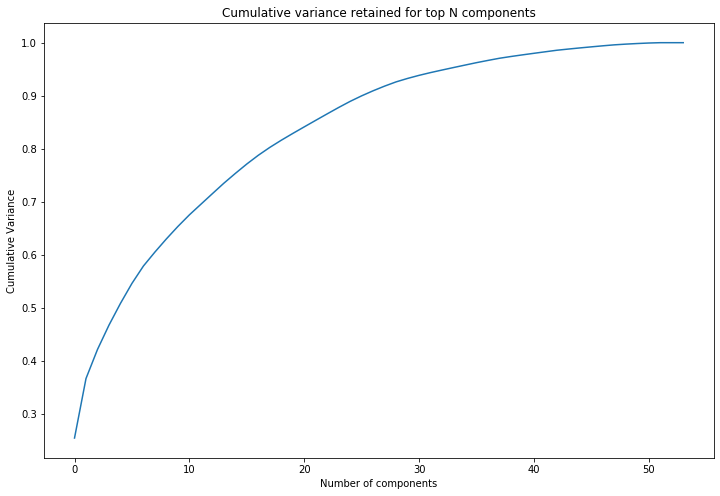

In [72]:
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt
# pca=PCA()
# X_trans = pca.fit_transform(traindonor_ohm)

# plt.figure(figsize=(12,8))
# plt.plot(np.cumsum(pca.explained_variance_ratio_));
# plt.title("Cumulative variance retained for top N components");
# plt.xlabel("Number of components");
# plt.ylabel("Cumulative Variance");

In [80]:
train_scaled_DF =pd.DataFrame(StandardScaler().fit_transform(traindonor_ohm.iloc[:,1:]))

In [81]:
val_scaled_DF = pd.DataFrame(StandardScaler().fit_transform(traindonor_ohm.iloc[:,1:]))

In [82]:
train_scaled_DF.head()

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,-0.1052,-0.047965,-0.143925,-0.076953,2.265430,-0.124351,-0.125983,-0.051947,-0.077758,-0.231163,...,-0.100257,-0.037539,-0.160898,-0.161276,-0.060541,-0.12114,-0.028019,-0.050068,-1.992677,1.992677
1,-0.1052,-0.047965,-0.143925,-0.076953,-0.441417,-0.124351,-0.125983,-0.051947,-0.077758,-0.231163,...,-0.100257,-0.037539,-0.160898,-0.161276,-0.060541,-0.12114,-0.028019,-0.050068,0.501837,-0.501837
2,-0.1052,-0.047965,-0.143925,-0.076953,-0.441417,-0.124351,-0.125983,-0.051947,-0.077758,-0.231163,...,-0.100257,-0.037539,-0.160898,-0.161276,-0.060541,-0.12114,-0.028019,-0.050068,0.501837,-0.501837
3,-0.1052,-0.047965,-0.143925,-0.076953,-0.441417,-0.124351,-0.125983,-0.051947,-0.077758,-0.231163,...,-0.100257,-0.037539,-0.160898,-0.161276,-0.060541,-0.12114,-0.028019,-0.050068,0.501837,-0.501837
4,-0.1052,-0.047965,-0.143925,-0.076953,-0.441417,-0.124351,-0.125983,-0.051947,-0.077758,-0.231163,...,-0.100257,-0.037539,-0.160898,-0.161276,-0.060541,-0.12114,-0.028019,-0.050068,0.501837,-0.501837


In [ ]:
cos_val_list_main =[]
for index1, row1 in train_scaled_DF.iterrows():
    cos_val_list=[]
    for index2,row2 in train_scaled_DF.iterrows():
# #         row1 = np.reshape(row1,(-1,2))
# #         row2 = np.reshape(row2,(-1,2))
#         print(np.ararow1)
#         print(type(row1))
#         print(row2)
#         print(type(row2))
        cosval = cosine_similarity(np.array(row1).reshape(1,-1), np.array(row2).reshape(1,-1))
        cos_val_list.append(cosval)
    cos_val_list_main.append(cos_val_list)
    
cos_val_df =pd.DataFrame(cos_val_list_main, columns = range(len(train_scaled_DF)))
    

In [84]:
cos_val_df.head()

,0,1,2,3,4,5,6,7,8,9,...,414298,414299,414300,414301,414302,414303,414304,414305,414306,414307


## One-Hot Vectorization of Features

In [ ]:
# checking for null values in the dataframe

trainNullCol = donationsTrainFinal.columns[donationsTrainFinal.isnull().any()]
donationsTrainFinal[trainNullCol].isnull().sum()

In [ ]:
# because we are doing content-based filtering, here are the features of the projects we are interested in:

ohFeatures = ['Project ID', 'Project Cost', 'Project Type','Project Subject Category Tree',
       'Project Grade Level Category', 'Project Resource Category',
       'Project Current Status',
       'School Metro Type', 'School State']

In [ ]:
# drop duplicates of projects because 'Project ID' has to be the primary key

projFeatures = donationsTrainFinal[ohFeatures].drop_duplicates(subset = ['Project ID'])

projFeatures = projFeatures.dropna() # drop the null values as well

print(projFeatures.shape)

In [ ]:
# no null values or duplicates

trainNullCol = projFeatures.columns[projFeatures.isnull().any()]
projFeatures[trainNullCol].isnull().sum()

In [ ]:
enc = OHE(handle_unknown='ignore')
enc.fit(projFeatures.iloc[:,2:]) # fit the one hot vector on our dataframe

In [ ]:
enc.categories_ # data dictionary of the OHM

In [ ]:
oneHotMatrix = pd.DataFrame(enc.transform(projFeatures.iloc[:,2:]).toarray()) # convert the one-hot matrix into a dataframe

In [ ]:
# this is what the OHM looks like

oneHotMatrix

## Merging one-hot matrix with the dataframe

In [ ]:
projOHM = pd.concat([projFeatures.reset_index(drop = True), oneHotMatrix.reset_index(drop = True)], axis = 1)

projOHM.head(1)


In [ ]:
dropCol = ['Project Type', 'Project Subject Category Tree', 'Project Grade Level Category',
           'Project Resource Category', 'Project Current Status',
           'School Metro Type', 'School State']

In [ ]:
# because we wanted to keep the project cost as one of the features,
# we vectorized the rest of features and vertically stacked the project cost

projOHM = projOHM.drop(dropCol, axis = 1)

projOHM.head(1)

In [ ]:
# data dictionary to track the one hot matrix

dataDict = enc.get_feature_names(dropCol) # please note that any new input should strictly should the indexes
                                            # mentioned in data dictionary

In [ ]:
del projOHM

In [ ]:
gc.collect()

## Building the recommendation system

In [ ]:
# scale and normalize the dataset

ohmDF = pd.DataFrame(StandardScaler().fit_transform(projOHM.iloc[:,1:]))

In [ ]:
# taking the first row as a sample row for the recommendation system

testRow = np.array(ohmDF.iloc[:1,:])

testRow

In [ ]:
# getting the cosine similarity between our feature matrix and test sample

test2 = cosine_similarity(ohmDF, testRow)

test2

In [ ]:
# tracing back the cosine similarity with their corresponding project ID
# so that we know what project does the similarity correspond to

test3 = pd.concat([projOHM.iloc[:,:1], pd.DataFrame(test2)], axis = 1)

test3 = test3.sort_values(by = 0, ascending = False) # sorting the similarity in descending order

In [ ]:
# checking if the recommendation system fares well
# here the recommended project has the same features, except the project cost

projFeatures[projFeatures['Project ID'] == '7d889853a64bcb23d0abc52bb21770b7']

In [ ]:
# checking if the recommendation system fares well v2

projFeatures[projFeatures['Project ID'] == 'e2beb818569f66adaa4ced21ca299ac6']

# Collaborative filtering

In [61]:
# scale and normalize the dataset
# Train dataset
train_ohmDF = pd.DataFrame(StandardScaler().fit_transform(traindonor_ohm.iloc[:,1:]))
# Validation dataset
val_ohmDF = pd.DataFrame(StandardScaler().fit_transform(valdonor_ohm.iloc[:,1:]))
# Normalizing gives memory error

In [ ]:
# Valid donor selected : 00006084c3d92d904a22e0a70f5c119a

In [64]:
# taking the first row of test data as a sample row for the recommendation system

testRow = np.array(val_ohmDF.iloc[:1,:])

testRow

array([[-0.11948439, -0.05199965, -0.12142712, -0.08338833, -0.38407723,
        -0.11648974, -0.13181684, -0.05536784, -0.06758773, -0.23475357,
        -0.17972976, -0.0605128 , -0.0646018 , -0.22371354, -0.14461157,
        -0.0768367 , -0.08838646, -0.1088863 , -0.11076027, -0.08024453,
        -0.1258358 , -0.16707833, -0.16983355, -0.12579243, -0.08617214,
        -0.14529605, -0.05189732, -0.05410448, -0.08802116, -0.06671374,
         6.27779291, -0.06435373, -0.26084354, -0.21556588, -0.03710346,
        -0.18191276, -0.13473467, -0.11245998, -0.19948582, -0.05449629,
        -0.16907405, -0.05107133, -0.11494116, -0.26575765, -0.09202064,
        -0.04231319, -0.16182131, -0.14590201, -0.06377121, -0.14871225,
        -0.0264282 , -0.16158028, -1.41959215,  1.41959215]])

In [65]:
# getting the cosine similarity between our train donors matrix and test sample

test2 = cosine_similarity(train_ohmDF, testRow)

test2

array([[ 0.18600333],
       [-0.0533146 ],
       [-0.0533146 ],
       ...,
       [-0.06483386],
       [ 0.11045184],
       [-0.02955231]])

In [69]:
# tracing back the cosine similarity with their corresponding donor ID
# so that we know which donor does the similarity correspond to

test3 = pd.concat([train_ohmDF.iloc[:,:1], pd.DataFrame(test2)], axis = 1)
test3.columns = [1,2]
test3.head()

,1,2
0,-0.1052,0.186003
1,-0.1052,-0.053315
2,-0.1052,-0.053315
3,-0.1052,-0.068854
4,-0.1052,-0.061167


In [70]:
test3 = test3.sort_values(by =2, ascending = False) # sorting the similarity in descending order

In [ ]:
# checking if the recommendation system fares well
# here the recommended project has the same features, except the project cost

projFeatures[projFeatures['Project ID'] == '7d889853a64bcb23d0abc52bb21770b7']

In [ ]:
# checking if the recommendation system fares well v2

projFeatures[projFeatures['Project ID'] == 'e2beb818569f66adaa4ced21ca299ac6']